In [17]:
import numpy as np
import matplotlib.pyplot as plt

cu = 3.e14   #speed of light in um/s
cA = 3.e18   #speed of light in A/s

In [18]:
def sum(array, lam):  #Sums the values in a template 
    a = len(array)
    tot = 0.
    
    for i in range(a-1):
        dlam = abs(lam[i+1] - lam[i])
        dnu = cu / lam[i]**2 * dlam

        tot += array[i] * dnu
        
    return tot

# WISE Objects

Reads in the data for the WISE objects in the g, r, J, Ks, W1, W2, W3, W4 bands, and converts them to the proper units of F_nu

In [19]:
def wise():       #Reads in the WISE data
    # Reads in the AB magnitudes, errors, and flux range in um for each object
    magAB = np.loadtxt('AB_mags.txt')
    errors = np.loadtxt('AB_errors.txt')
    with open('objects.txt') as f:
        objects = f.readlines()
        objects = [line.rstrip('\n') for line in open('objects.txt')]
    
    wise_flux = np.zeros((15,8))
    wise_fluxerr = np.zeros((15,8))

    for i in range(15):
        for j in range(8):
            if errors[i,j] == 9.999:
                errors[i,j] = 0.000
            if magAB[i,j] == 0.:
                continue
            wise_flux[i,j] = 10**(-0.4*(magAB[i,j] - 8.926))
            wise_fluxerr[i,j] = 10**(-0.4*(magAB[i,j] + errors[i,j] - 8.926))
    
    wise_error = np.log10(wise_fluxerr) - np.log10(wise_flux)

    #Array containing the wavelengths for each WISE object in each band: (g r J Ks W1 W2 W3 W4)
    wise_lam = np.zeros((15,8))
    z = (1,0.47,1,1,1,1,1,1,2.25,1,0.7,1.08,1.8,1,1)

    for i in range(15):
        wise_lam[i] = (0.474, 0.620, 1.247, 2.163, 3.4, 4.6, 12., 22.)
        #wise_lam[i] /= (z[i] + 1)
        
    #WISE values of row1: W2 - W3, and row2: W1 - W2
    wise_w123 = np.zeros((2,15))
    for i in range(15):
        #The magnitudes are converted back into Vega mags, which were the magnitudes used by Lonsdale et. al.
        wise_w123[0,i] = (magAB[i,5] - 3.339) - (magAB[i,6] - 5.174)
        wise_w123[1,i] = (magAB[i,4] - 2.699) - (magAB[i,5] - 3.339)
        
    return wise_flux, wise_lam, wise_error, wise_w123, objects

# Templates

In [20]:
def load_gal():
    galaxy = np.zeros((10,300))
    names = ['ELL2','ELL5','ELL13','S0','Sa','Sb','Sc','Sd','M82','ARP220']

    ELL2_orig = np.loadtxt('templates_recast/ELL2.txt')
    ELL5_orig = np.loadtxt('templates_recast/ELL5.txt')
    ELL13_orig = np.loadtxt('templates_recast/ELL13.txt')
    S0_orig = np.loadtxt('templates_recast/S0.txt')
    Sa_orig = np.loadtxt('templates_recast/Sa.txt')
    Sb_orig = np.loadtxt('templates_recast/Sb.txt')
    Sc_orig = np.loadtxt('templates_recast/Sc.txt')
    Sd_orig = np.loadtxt('templates_recast/Sd.txt')
    M82_orig = np.loadtxt('templates_recast/M82.txt')
    ARP220_orig = np.loadtxt('templates_recast/ARP220.txt')
    
    galaxy[0] = ELL2_orig[0]
    galaxy[1] = ELL5_orig[0]
    galaxy[2] = ELL13_orig[0]
    galaxy[3] = S0_orig[0]
    galaxy[4] = Sa_orig[0]
    galaxy[5] = Sb_orig[0]
    galaxy[6] = Sc_orig[0]
    galaxy[7] = Sd_orig[0]
    galaxy[8] = M82_orig[0]
    galaxy[9] = ARP220_orig[0]
    
    return galaxy, names

In [21]:
def gal_ad(gal_orig, qso_orig, p):
    gal = np.zeros(len(gal_orig))

    gal[237] = qso_orig[237] / p
    x = gal[237] / gal_orig[237]
    for j in range(len(gal_orig)):
        gal[j] = gal_orig[j] * x
        
    return gal

In [29]:
def reddening(qso_orig, lam, A_V):
    R_V = 4.05

    A_lam = np.zeros(len(lam)) #Actually calculating A_lam / A_V

    const = (2.659/R_V * (-1.857 + 1.04/2.2) + 1.0) / 2.2**-1.75
    const1 = (2.659/R_V * (-2.156 + 1.509/0.1 - 0.198/(0.1**2) + 0.011/(0.1**3)) + 1.0) * 0.1**1.8
        
    for i in range(len(lam)):
        if lam[i] >= 0.1:
            if lam[i] < 0.63:
                A_lam[i] = 2.659/R_V * (-2.156 + 1.509/lam[i] - 0.198/(lam[i]**2) + 0.011/(lam[i]**3)) + 1.0
        if lam[i] >= 0.63:
            if lam[i] <= 2.20:
                A_lam[i] = 2.659/R_V * (-1.857 + 1.04/lam[i]) + 1.0
            elif lam[i] > 2.20:
                A_lam[i] = const * lam[i]**-1.75
        if lam[i] < 0.12:
            A_lam[i] = const1 * lam[i]**-1.8
    
    QSO_red = np.zeros(len(qso_orig))
    
    for i in range(len(qso_orig)):
        QSO_red[i] = qso_orig[i] * 10**(-0.4 * A_V * A_lam[i])
        
    return QSO_red

In [30]:
def planck(lam, p_lam, qso_orig, qso_red, T):
    planck = p_lam**(-3) / (np.exp(14400. / p_lam / T)-1)    #Planck function
    
    dust_abs = sum(qso_orig,lam) - sum(qso_red,lam)
    planck_func = np.zeros(len(p_lam))

    alpha = dust_abs / sum(planck,p_lam)
    planck_func = planck * alpha
    
    return planck_func

In [31]:
def norm(template, lam, wise_flux, wise_lam):  #normalizes to template to the g-band point of the WISE data
    c = 0.
    tot = 0.
    temp = np.zeros(len(template))
    
    for k in range(len(template)):  #making a new, cloned template, because without doing this it update the input 
        temp[k] = template[k]       #template, and I don't want that
        
    for j in range(len(lam)):
        if lam[j] >= wise_lam - 0.02:
            if lam[j] <= wise_lam + 0.02:
                c += 1.
                tot += temp[j]
    avg = tot / c
    
    x = avg / wise_flux
    temp /= x
    
    return temp

C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in log10
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in subtract
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log10
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: divide by zero encountered in log10
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: divide by zero encountered in log10
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: divide by zero encountered in log10
C:\Users\student\Anaconda2\lib\site-packages\ipykernel\__main__.py:63: RuntimeWarning: divide by zero enc

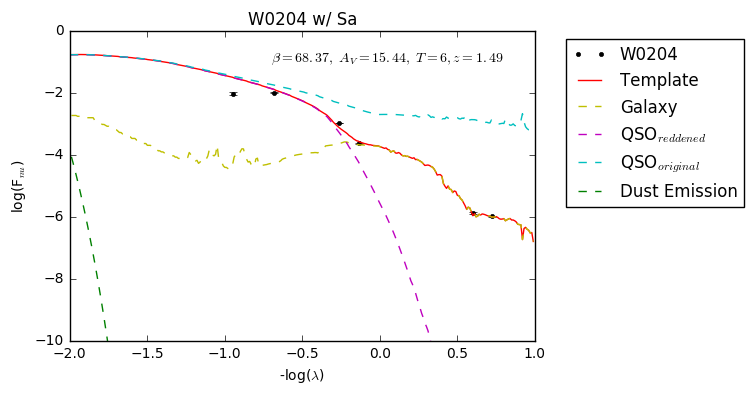

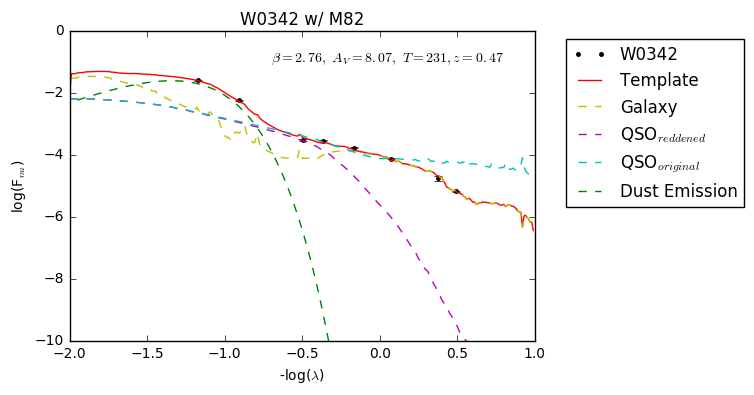

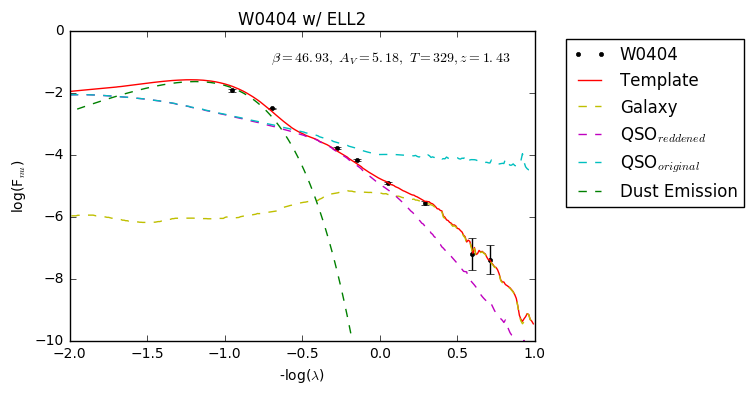

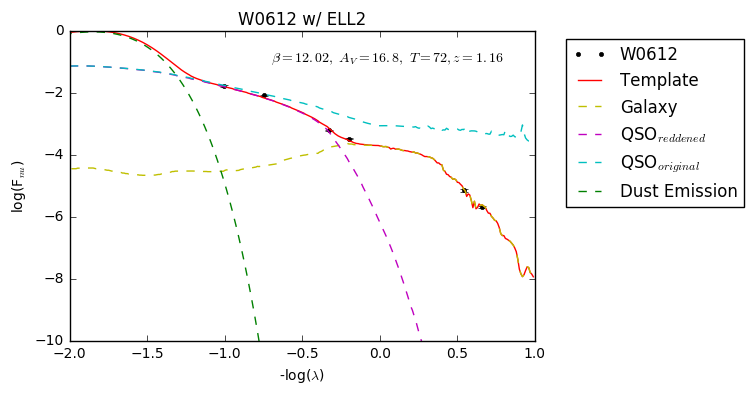

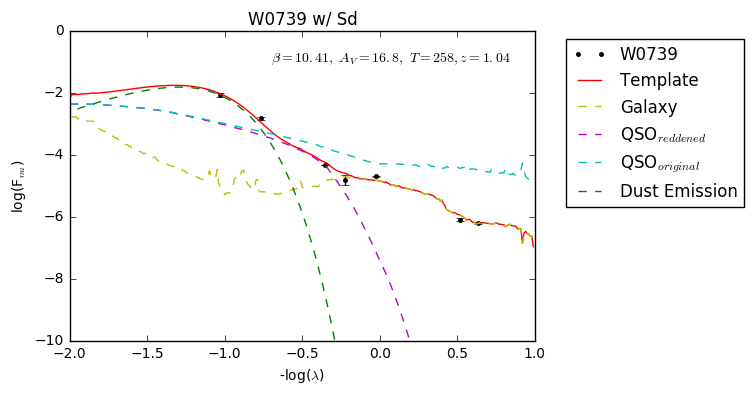

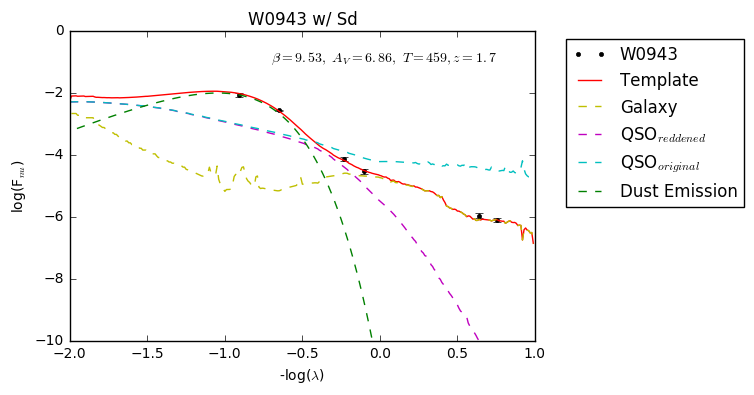

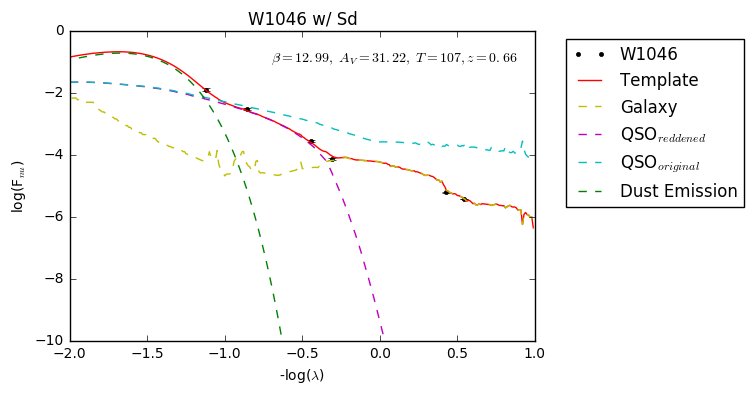

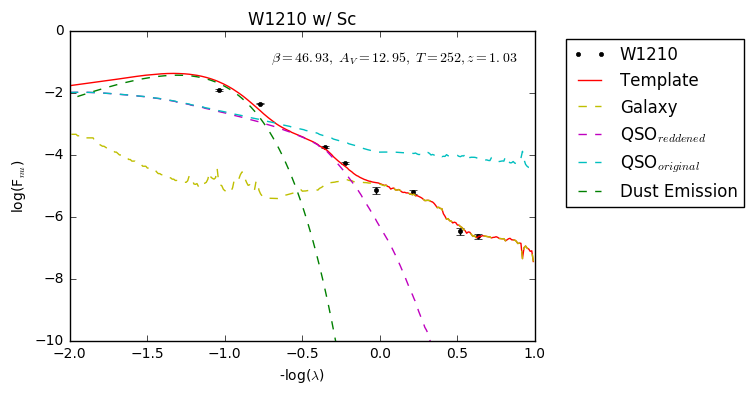

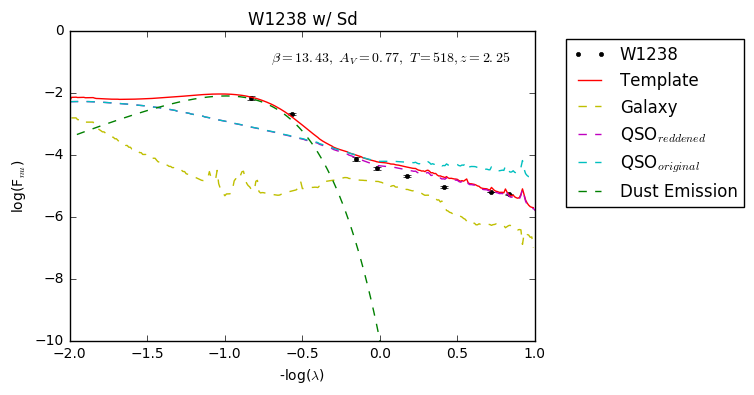

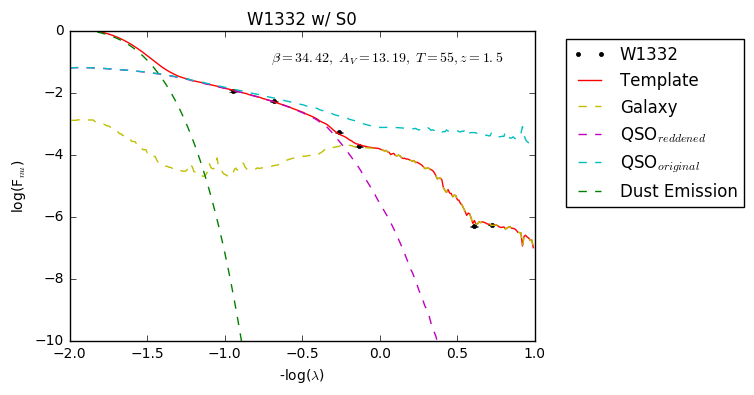

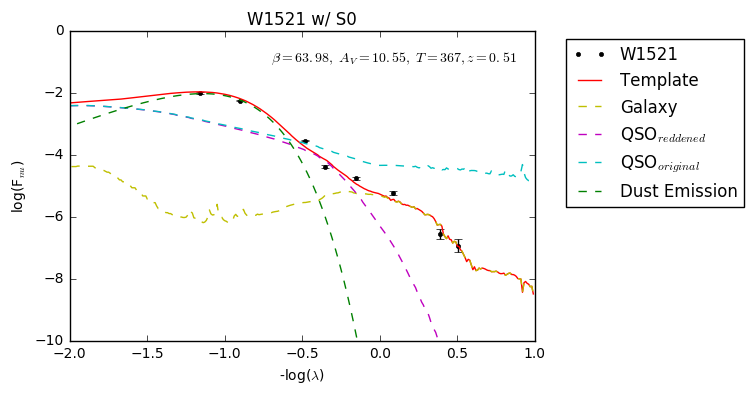

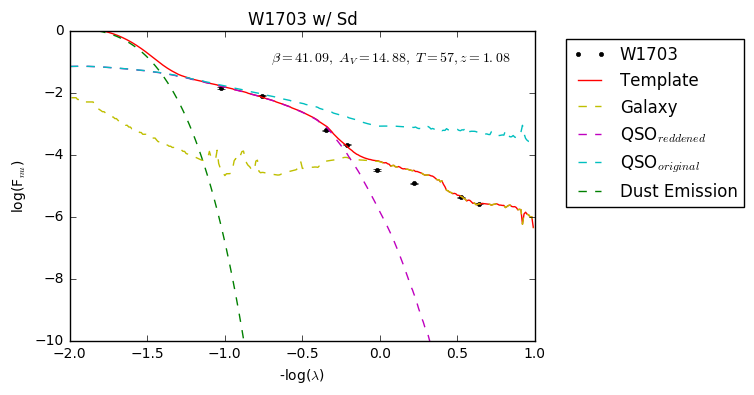

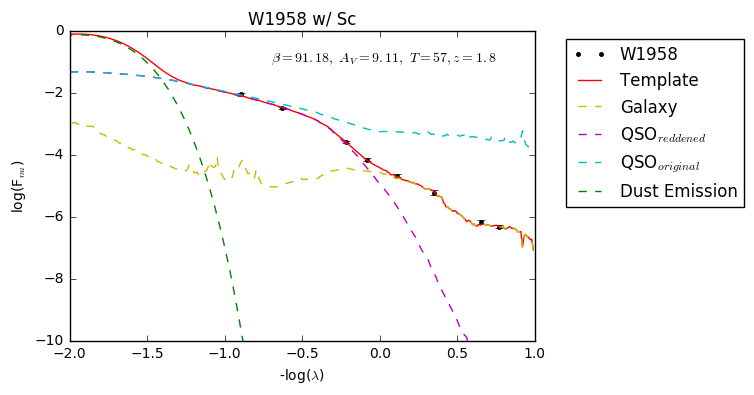

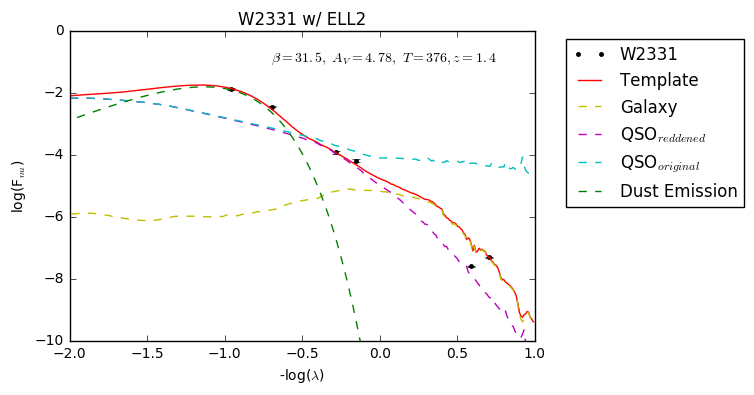

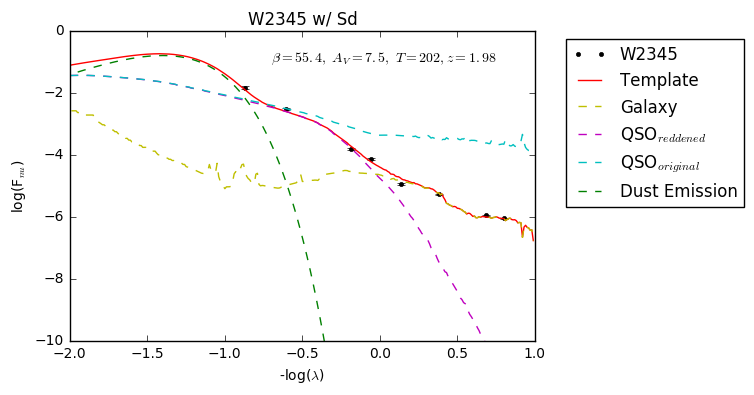

In [34]:
#loads WISE data
wise_flux, wise_lam, wise_error, wise_w123, objects = wise()

#The data from these templates is in two rows, the first row containing the flux, the second row containing the wavelength
#The flux is in units of [erg cm-2 s-1 Hz-1], while the wavelength is in [um]
QSO_orig = np.loadtxt('templates_recast/QSO1.txt')

galaxy, gal_names = load_gal()

params = np.loadtxt('parameters2.txt')      #File of parameters output from slider program
                                           #The parameters in each row are in order:  P A_V T z a b
a = []                                     #a indicates object
b = []                                     #b indicates galaxy type
for i in range(len(params)):
    a.append(int(params[i,4]))
    b.append(int(params[i,5]))

lam = QSO_orig[1]                   #array of wavelengths
negloglam = -np.log10(lam)          #array of -log(wavelength), [-2,1]
QSO_negloglam = np.arange(-2,3,0.01)        #array of new -log(wavelength) for QSO [-2,3]
QSO_lam = 10**(-QSO_negloglam)              #new QSO lambda
p_negloglam = np.arange(-3,1,0.01)   #array of -log(wavelength) for planck function, [-3,1]
p_lam = 10**(-p_negloglam)           #array of wavelengths for planck function

QSO_new = np.zeros(len(QSO_negloglam))

for i in range(len(QSO_negloglam)):         #expands Quasar another 2 dex, setting it as const in nu*F_nu
    if i <= 299:
        QSO_new[i] = QSO_orig[0][i]
    else:
        QSO_new[i] = QSO_orig[0][299] * QSO_lam[i] / QSO_lam[299]

for i in range(len(params)):
    wise_lam_new = wise_lam[a[i]] / (params[i,3] + 1)
    
    gal = gal_ad(galaxy[b[i]], QSO_orig[0], params[i,0]) 
    QSO_red = reddening(QSO_new, QSO_lam, params[i,1])
    p_func = planck(QSO_lam, p_lam, QSO_new, QSO_red, params[i,2])
    
    template = np.zeros(len(lam))

    for j in range(len(gal)):
        template[j] += gal[j]
        template[j] += QSO_red[j]
        template[j] += p_func[j+100]
        
    temp = norm(template, lam, wise_flux[a[i],0], wise_lam_new[0])     #normalizes the template to the g-band
    n_factor = np.log10(temp[1]) - np.log10(template[1])
    
    plt.figure(i+1)
    plt.axis([-2,1,-10,-0])
    plt.title(str(objects[a[i]]) + ' w/ ' + str(gal_names[b[i]]))
    plt.xlabel('-log($\lambda$)')
    plt.ylabel('log(F$_{nu}$)')
    
    plt.plot(-np.log10(wise_lam_new), np.log10(wise_flux[a[i]]), 'k.', label=objects[a[i]])
    plt.errorbar(-np.log10(wise_lam_new), np.log10(wise_flux[a[i]]), yerr=wise_error[a[i]], fmt='none', ecolor='k')
    
    plt.plot(negloglam, np.log10(temp), 'r-', label='Template')
    plt.plot(negloglam, np.log10(gal)+n_factor, 'y--', label='Galaxy')
    plt.plot(QSO_negloglam, np.log10(QSO_red)+n_factor, 'm--', label='QSO$_{reddened}$')
    plt.plot(negloglam, np.log10(QSO_orig[0])+n_factor, 'c--', label='QSO$_{original}$')
    plt.plot(p_negloglam, np.log10(p_func)+n_factor, 'g--', label='Dust Emission')
    plt.text(-0.7, -1, r'$\beta=' + str(round(params[i,0],2)) + ',\ A_V=' + str(round(params[i,1],2)) + ',\ T=' + 
                      str(int(params[i,2])) + ', z=' + str(round(params[i,3],2)) + '$')
    
    plt.legend(bbox_to_anchor=(1.05,1), loc=2)
    
    plt.savefig('SEDs/' + objects[a[i]] + '_' + gal_names[b[i]] + '.png', bbox_inches='tight')
    
    plt.show()
    